In [1]:
from pandas import read_csv
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM ,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.express as px
import plotly.graph_objects as go

### Set up common fuctions

In [8]:


# UTILITY
def plotly_line_plot(t,y,title="Plot",x_label="t: time (months)",y_label="y(t): Response variable"):

    # GENERATE PLOTLY FIGURE
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t[0], y=y[0],
                    mode='lines',
                    name='train',line=dict(color='rgb(49,130,189)', width=4)))
    #fig = px.line(x=t[0],y=y[0], title=title, render_mode='SVG', symbol="train")  
    # IMPORTANT: SVG FIXES RENDER ISSUES WITH SAD FACE 
    # https://community.plotly.com/t/plotly-express-line-charts-are-not-shown/39715
    
    # ADD MORE
    for i in range(1,len(y)):
        if len(t[i])==1:
            #print(t[i],y[i])
            fig.add_trace(go.Scatter(x=t[i],y=y[i], name='validation'))
        else:
            fig.add_trace(go.Scatter(x=t[i],y=y[i], mode='lines', name='validation'))

    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white"
    )
    return fig


# Parameter split_percent defines the ratio of training examples
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data


# PREPARE THE INPUT X AND TARGET Y
def get_XY(dat, time_steps,plot_data_partition=False):
    global X_ind,X,Y_ind,Y #use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps); #print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind=[*range(time_steps*rows_x)]
    del X_ind[::time_steps] #if time_steps=10 remove every 10th entry
    X = dat[X_ind]; 

    #PLOT
    if(plot_data_partition):
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y,'o',X_ind, X,'-'); plt.show(); 

    #RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps-1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y






### US Inflation - measured by CPI

In [84]:
df = read_csv('../data/us_cpi_if.csv', engine='python')
X = np.array(df["Inflation"].values.astype('float32')).reshape(df.shape[0],1)


#SINGLE SERIES 
t=[*range(0,len(X))]
f=plotly_line_plot([t],[X[:,0]],title="US inflation per month since 2002-01")
f.write_html("Inflation.html",full_html=False )

### US CPI

In [44]:
df = read_csv('../data/us_cpi_if.csv', engine='python')
X = np.array(df["CPI"].values.astype('float32')).reshape(df.shape[0],1)


#SINGLE SERIES 
t=[*range(0,len(X))]
f=plotly_line_plot([t],[X[:,0]],title="US CPI per month since 2002-01")
f.write_html("CPI.html")

Training part is same for each series, run different X to analyze inflation or CPI.

In [85]:

train_data, test_data, data = get_train_test(X)

print(train_data.shape)
print(test_data.shape)
# SINGLE SERIES 
t1=[*range(0,len(train_data))]
t2=len(train_data)+np.array([*range(0,len(test_data))])
plotly_line_plot([t1,t2],[train_data,test_data],title="Train Test Split")

(201,)
(51,)


Inflation model AR(2)

In [86]:
#PARTITION DATA
p=2 # simpilar to AR(p) given time_steps data points, predict time_steps+1 point (make prediction one month in future)
# according to PACF plot of Inflation in ARIMA tab, p should be 2



CPI model AR(1)

In [46]:
p=1 # simpilar to AR(p) given time_steps data points, predict time_steps+1 point (make prediction one month in future)
# according to PACF plot of CPI in ARIMA tab, p should be 1

In [87]:
testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [88]:
print(testX.shape,testY.shape)
print(trainX.shape,trainY.shape)
print(type(trainX))

(25, 1, 1) (25,)
(100, 1, 1) (100,)
<class 'numpy.ndarray'>


In [89]:
#USER PARAM
recurrent_hidden_units=3
epochs=200
f_batch=0.2    #fraction used for batch size
optimizer="RMSprop"
validation_split=0.2
print(trainX.shape,p,trainY.shape)

# trainY=trainY.reshape(trainY.shape[0],1)
# testY=testY.reshape(testY.shape[0],1)
print(p,trainX.shape,testX.shape,trainY.shape,testY.shape)

(100, 1, 1) 2 (100,)
2 (100, 1, 1) (25, 1, 1) (100,) (25,)


In [90]:
from tensorflow.keras import regularizers


######## RNN ########

model_R = Sequential()
model_R.add(SimpleRNN(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
activation='tanh')
          )     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_R.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_R.compile(loss='MeanSquaredError', optimizer=optimizer)
model_R.summary()



######## RNN with regularization ########

model_RL = Sequential()
model_RL.add(SimpleRNN(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-2),
activation='tanh')
          )     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_RL.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_RL.compile(loss='MeanSquaredError', optimizer=optimizer)
model_RL.summary()


######## GRU ########

model_G = Sequential()
model_G.add(GRU(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
activation='tanh')
          )     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_G.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_G.compile(loss='MeanSquaredError', optimizer=optimizer)
model_G.summary()



######## GRU with regularization ########

model_GL = Sequential()
model_GL.add(GRU(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-2),
activation='tanh')
          )     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_GL.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_GL.compile(loss='MeanSquaredError', optimizer=optimizer)
model_GL.summary()


######## LSTM ########

model_M = Sequential()
model_M.add(LSTM(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
activation='tanh')
          ) 
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_M.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_M.compile(loss='MeanSquaredError', optimizer=optimizer)
model_M.summary()


######## LSTM with regularization ########

#CREATE MODEL
model_ML = Sequential()
model_ML.add(LSTM(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-2),
activation='tanh')
          ) 
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model_ML.add(Dense(units=1, activation='linear'))
# COMPILE THE MODEL 
model_ML.compile(loss='MeanSquaredError', optimizer=optimizer)
model_ML.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 3)                 15        
                                                                 
 dense_24 (Dense)            (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 3)                 15        
                                                                 
 dense_25 (Dense)            (None, 1)                 4         
                                                                 
Total params: 19
Trainable params:

In [91]:
def trainmodel(m):
    history = m.fit(
                trainX, trainY, 
                epochs=epochs, 
                batch_size=int(f_batch*trainX.shape[0]), 
                validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
                verbose=2)
    
    

    # MAKE PREDICTIONS
    train_predict = m.predict(trainX).squeeze()
    test_predict = m.predict(testX).squeeze()

    #COMPUTE RMSE
    train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = np.sqrt(mean_squared_error(testY, test_predict))

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    return (train_rmse, test_rmse, loss, val_loss, train_predict, test_predict)

In [92]:
(train_rmse_R,test_rmse_R, loss_R, val_loss_R, train_predict_R, test_predict_R)=trainmodel(model_R)
(train_rmse_RL,test_rmse_RL, loss_RL, val_loss_RL, train_predict_RL, test_predict_RL)=trainmodel(model_RL)
(train_rmse_G,test_rmse_G, loss_G, val_loss_G, train_predict_G, test_predict_G)=trainmodel(model_G)
(train_rmse_GL,test_rmse_GL, loss_GL, val_loss_GL, train_predict_GL, test_predict_GL)=trainmodel(model_GL)
(train_rmse_M,test_rmse_M, loss_M, val_loss_M, train_predict_M, test_predict_M)=trainmodel(model_M)
(train_rmse_ML,test_rmse_ML, loss_ML, val_loss_ML, train_predict_ML, test_predict_ML)=trainmodel(model_ML)

Epoch 1/200
4/4 - 1s - loss: 0.0406 - val_loss: 0.0229 - 638ms/epoch - 160ms/step
Epoch 2/200
4/4 - 0s - loss: 0.0320 - val_loss: 0.0181 - 21ms/epoch - 5ms/step
Epoch 3/200
4/4 - 0s - loss: 0.0267 - val_loss: 0.0146 - 21ms/epoch - 5ms/step
Epoch 4/200
4/4 - 0s - loss: 0.0227 - val_loss: 0.0118 - 23ms/epoch - 6ms/step
Epoch 5/200
4/4 - 0s - loss: 0.0193 - val_loss: 0.0095 - 22ms/epoch - 6ms/step
Epoch 6/200
4/4 - 0s - loss: 0.0165 - val_loss: 0.0075 - 23ms/epoch - 6ms/step
Epoch 7/200
4/4 - 0s - loss: 0.0141 - val_loss: 0.0059 - 22ms/epoch - 6ms/step
Epoch 8/200
4/4 - 0s - loss: 0.0120 - val_loss: 0.0046 - 22ms/epoch - 6ms/step
Epoch 9/200
4/4 - 0s - loss: 0.0102 - val_loss: 0.0035 - 21ms/epoch - 5ms/step
Epoch 10/200
4/4 - 0s - loss: 0.0088 - val_loss: 0.0027 - 22ms/epoch - 6ms/step
Epoch 11/200
4/4 - 0s - loss: 0.0076 - val_loss: 0.0021 - 23ms/epoch - 6ms/step
Epoch 12/200
4/4 - 0s - loss: 0.0066 - val_loss: 0.0017 - 22ms/epoch - 5ms/step
Epoch 13/200
4/4 - 0s - loss: 0.0058 - val_los

In [93]:
df = pd.DataFrame(np.array([['RNN',train_rmse_R,test_rmse_R],['RNN with Regularization',train_rmse_RL,test_rmse_RL],['GRU',train_rmse_G,test_rmse_G] , ['GRU with Regularization',train_rmse_GL, test_rmse_GL], ['LSTM',train_rmse_M, test_rmse_M], ['LSTM with Regularization',train_rmse_ML, test_rmse_ML]]),
                   columns=['Model','Train RMSE', 'Test RMSE'])
df

,Model,Train RMSE,Test RMSE
0,RNN,0.046720874,0.07962988
1,RNN with Regularization,0.046680972,0.06865834
2,GRU,0.047126103,0.06481308
3,GRU with Regularization,0.046988506,0.06584781
4,LSTM,0.0625542,0.11685007
5,LSTM with Regularization,0.06637252,0.13628882


In [95]:
df.to_csv('Inflation.csv', index=False) 
# df.to_csv('CPI.csv', index=False) 

In [60]:
# PLOTLY PLOT
#HISTORY PLOT
epochs_steps = [*range(0, len(loss_R))]

a=plotly_line_plot([epochs_steps,epochs_steps],[loss_R,val_loss_R],title="RNN Loss",x_label="training epochs",y_label="loss (MSE)")

b=plotly_line_plot([epochs_steps,epochs_steps],[loss_RL,val_loss_RL],title="RNN with regularization Loss",x_label="training epochs",y_label="loss (MSE)")

c=plotly_line_plot([epochs_steps,epochs_steps],[loss_G,val_loss_G],title="GRU Loss",x_label="training epochs",y_label="loss (MSE)")

d=plotly_line_plot([epochs_steps,epochs_steps],[loss_GL,val_loss_GL],title="GRU with regularization Loss",x_label="training epochs",y_label="loss (MSE)")

e=plotly_line_plot([epochs_steps,epochs_steps],[loss_M,val_loss_M],title="LSTM Loss",x_label="training epochs",y_label="loss (MSE)")

f=plotly_line_plot([epochs_steps,epochs_steps],[loss_ML,val_loss_ML],title="LSTM with regularization Loss",x_label="training epochs",y_label="loss (MSE)")


In [27]:
a.write_html("InflationR.html")
b.write_html("InflationRL.html")
c.write_html("InflationG.html")
d.write_html("InflationGL.html")
e.write_html("InflationM.html")
f.write_html("InflationML.html")

In [61]:
a.write_html("CPIR.html")
b.write_html("CPIRL.html")
c.write_html("CPIG.html")
d.write_html("CPIGL.html")
e.write_html("CPIM.html")
f.write_html("CPIML.html")

Text(0.5, 1.0, 'Actual and Predicted Values. The Black Line Separates The Training And Test Examples')

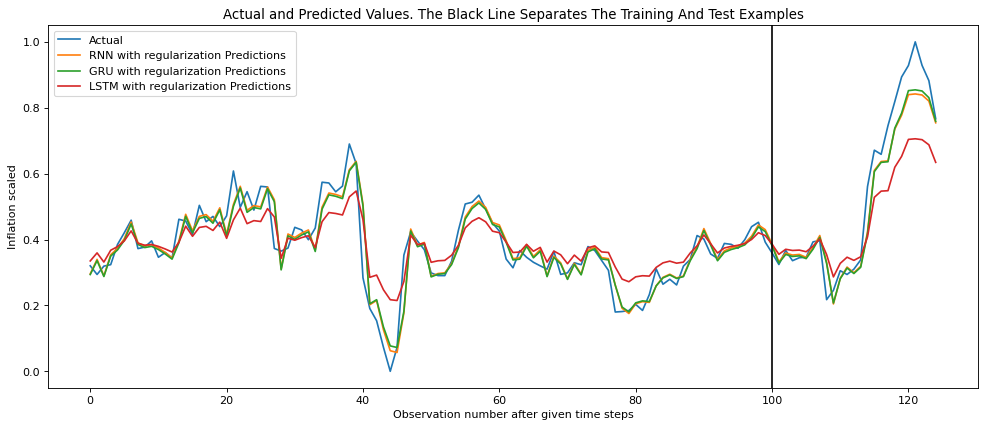

In [94]:
actual = np.append(trainY, testY)
pred_R = np.append(train_predict_R, test_predict_R)
pred_RL = np.append(train_predict_RL, test_predict_RL)
pred_G = np.append(train_predict_G, test_predict_G)
pred_GL = np.append(train_predict_GL, test_predict_GL)
pred_M = np.append(train_predict_M, test_predict_M)
pred_ML = np.append(train_predict_ML, test_predict_ML)
rows = len(actual)
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(range(rows), actual)
#plt.plot(range(rows), pred_R)
plt.plot(range(rows), pred_RL)
#plt.plot(range(rows), pred_G)
plt.plot(range(rows), pred_GL)
#plt.plot(range(rows), pred_M)
plt.plot(range(rows), pred_ML)
plt.axvline(x=len(trainY), color='black')
plt.legend(['Actual', 'RNN with regularization Predictions','GRU with regularization Predictions','LSTM with regularization Predictions'])
plt.xlabel('Observation number after given time steps')
plt.ylabel('Inflation scaled')
plt.title('Actual and Predicted Values. The Black Line Separates The Training And Test Examples')

